## Lab: MNIST Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

In [1]:
!pip install tensorflow_datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   ---------------------------------------- 5.1/5.1 MB 38.7 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21544 sha256=7c83af39026f624300c4f9be0701e7d6588656a05a36eafbd3351d0c973c1c4b
  Stored in directory: c:\users\anany\appdata\local\pip\cache\wheels\90\74\b1\9b54c896b8d9409e9268329d4d45ede8a8040abe91c8879932
Successfully built promise


## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [3]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

In [4]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

C:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 2/4 [00:01<00:01,  1.17 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:02<00:00,  1.74 url/s]


Dataset mnist downloaded and prepared to C:\Users\anany\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

In [5]:
def simple_autoencoder(inputs):
  '''Builds the encoder and decoder using Dense layers.'''
  # START YOUR CODE HERE
  encoder = tf.keras.layers.Dense(128, activation='relu')(inputs)  # First hidden layer with 128 units
  encoder = tf.keras.layers.Dense(64, activation='relu')(encoder)  # Second hidden layer with 64 units
  encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)  # Bottleneck layer with 32 units

  # Decoder: Reconstructs the input from the lower-dimensional representation
  decoder = tf.keras.layers.Dense(64, activation='relu')(encoder)  # First hidden layer with 64 units
  decoder = tf.keras.layers.Dense(128, activation='relu')(decoder)  # Second hidden layer with 128 units
  decoder = tf.keras.layers.Dense(784, activation='sigmoid')(decoder)  # Output layer with 784 units (same as input)
  # END YOUR CODE HERE
  return encoder, decoder

# set the input shape
inputs =  tf.keras.layers.Input(shape=(784,))

# get the encoder and decoder output
encoder_output, decoder_output = simple_autoencoder(inputs)

# setup the encoder because you will visualize its output later
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup the autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [6]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy')

## Train the Model

In [8]:
train_steps = 60000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=10)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1084
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1052
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1027
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1006
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0984
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0967
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0955
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0941
Epoch 9/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0931
Epoch 10/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0922


## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [9]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


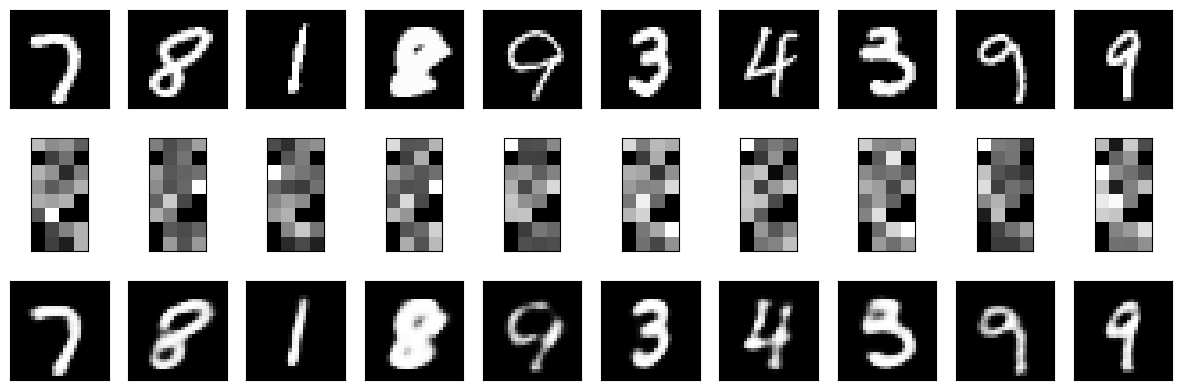

In [10]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])